# Projeto 1 - Ciência dos Dados

Nome: Isabelle Moschini Murollo

Nome: Maia Fleider

Nome: Natália Queiroz Menezes Carreras

**Atenção:** Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

**Em `filename`, coloque o nome do seu arquivo de dados!**

In [2]:
catupiry = 'catupiry.xlsx'
if catupiry in os.listdir():
    print(f'Encontrei o arquivo {catupiry}, tudo certo para prosseguir com a prova!')
else:
    print(f'Não encontrei o arquivo {catupiry} aqui no diretório {os.getcwd()}, será que você não baixou o arquivo?')

Encontrei o arquivo catupiry.xlsx, tudo certo para prosseguir com a prova!


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [3]:
train = pd.read_excel(catupiry)
train.head(5)

,Treinamento,RELEVANCIA
0,"viciei em hambúrguer com catupiry rota, por qu...",3
1,@balalirica empadão de frango com catupiry fei...,1
2,"coisas inúteis sobre mim\naltura — 1,78\nidade...",2
3,uma pizza de frango com catupiry no café da manhã,1
4,nossa queria uma pizza de frango com catupiry ...,2


In [4]:
test = pd.read_excel(catupiry, sheet_name = 'Teste')
test.head(5)

,Teste,RELEVANCIA
0,hoje eu sonhei que tava de rolê aqui pertinho ...,0
1,@essediafoilouco pizza de frango com catupiry ...,2
2,@jubaqueen frango com catupiry e banana com ca...,2
3,"@df_porto a @tweetsdaphri não é mineira, mas é...",0
4,"isso aqui! (tirando a parte de encher a cara, ...",0


___
## Classificador automático de sentimento


Faça aqui uma descrição do seu produto e o que considerou como relevante ou não relevante na classificação dos tweets.

Nós consideramos que os tweets mais relevantes para o produto seriam aqueles que realizassem comentários positivos ou comentários negativos, enquanto os menos relevantes seriam não relacionados diretamente ao produto.

Assim, construímos a seguinte escala:

0 - comentários não relacionados (irrelevante)

1 - comentários neutros ou que não agregassem ao produto (neutro)

2 - comentários positivos e elogios (relevante)

3 - comentários que envolviam sentimentos positivos muito fortes ou comentários negativos (muito relevante)


___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

##### Importando as bibliotecas necessárias:

In [5]:
import pandas as pd
import emoji
from math import *
import re
from IPython.display import display
pd.options.display.max_rows = 13

##### Categorizando as classificações:

In [6]:
#Para o treinamento
train['RELEVANCIA']=train['RELEVANCIA'].astype('category')

train['RELEVANCIA'].cat.categories = ['Irrelevante', 'Neutro', 'Relevante', 'Muito Relevante']

filtra_irrelevantes = train['RELEVANCIA']=='Irrelevante'
filtra_neutro = train['RELEVANCIA']=='Neutro'
filtra_relevante = train['RELEVANCIA']=='Relevante'
filtra_muito_relevante = train['RELEVANCIA']=='Muito Relevante'

irrelevante = train.loc[filtra_irrelevantes,:]
neutro = train.loc[filtra_neutro,:]
relevante = train.loc[filtra_relevante,:]
muito_relevante = train.loc[filtra_muito_relevante,:]

#Para o teste
test['RELEVANCIA']=test['RELEVANCIA'].astype('category')

test['RELEVANCIA'].cat.categories = ['Irrelevante', 'Neutro', 'Relevante', 'Muito Relevante']

filtra_irrelevantes_teste = test['RELEVANCIA']=='Irrelevante'
filtra_neutro_teste = test['RELEVANCIA']=='Neutro'
filtra_relevante_teste = test['RELEVANCIA']=='Relevante'
filtra_muito_relevante_teste = test['RELEVANCIA']=='Muito Relevante'

irrelevante_teste = test.loc[filtra_irrelevantes_teste,:]
neutro_teste = test.loc[filtra_neutro_teste,:]
relevante_teste = test.loc[filtra_relevante_teste,:]
muito_relevante_teste = test.loc[filtra_muito_relevante_teste,:]

##### Criando as funções para limpeza:

In [7]:
#REMOVENDO PONTUAÇÕES:
def cleanup(tweet):
    punctuation = '[!-.:?;\"\n()\',—•]'
    pattern = re.compile(punctuation)
    tweet_subbed = re.sub(pattern, '', tweet)
    return tweet_subbed

In [8]:
#Removendo links de sites
def cleanhttp(tweet):
    site = 'http[^\s]*'
    pattern = re.compile(site)
    tweet_subbed_site = re.sub(pattern, '', tweet)
    return tweet_subbed_site

In [9]:
#Separando emojis uns dos outros e de palavras
def clean_emoji(texto):
    novo_texto = ''
    for character in texto:
        if character in emoji.UNICODE_EMOJI:
            novo_texto += ' ' + character + ' '
        else:
            novo_texto += character
    return novo_texto

In [10]:
#Removendo palavras pouco relevantes para classificar os tweets, como preposições
def clean_palavras2(lista):
    nova_lista = []
    lista_palavras = ['a', 'e', 'o', 'em', 'de', 'da', 'do', 'eh', 'é', 'que', 'q', 'pra', 'pro', 'para', \
                      'com', 'na', 'no', 'por', 'das', 'dos', 'nas', 'nos']
    for palavra in lista:
        if palavra in lista_palavras:
            nova_lista = nova_lista
        else:
            nova_lista.append(palavra)
    return nova_lista

##### Implementando as funções para limpeza:

In [11]:
#Espaçando as frases uma das outras:
treinamento_string = ""
for tweet in train.Treinamento:
    treinamento_string += " "+tweet
    
#Deixando tudo em letras minúsculas:
treinamento_lower = cleanup(treinamento_string.lower())

#Apagando links:
treinamento_site = cleanhttp(treinamento_lower)

#Separando emojis:
treinamento_emojis = clean_emoji(treinamento_site)

#Separando as palavras:
separacao_treinamento = treinamento_emojis.split()

#Tirando palavras pouco relevantes, como preposições:
tweet_sem_palavras = clean_palavras2(separacao_treinamento) 

#Transformando lista de palavras em tabela de palavras:
serie_treinamento = pd.Series(tweet_sem_palavras)

In [12]:
#IRRELEVANTES:
#Espaçando as frases uma das outras:
treinamento_irrelevantes = ""
for i in irrelevante.Treinamento:
    treinamento_irrelevantes += " "+i

#Deixando tudo em letras minúsculas:
treinamento_lower_irrelevantes = cleanup(treinamento_irrelevantes.lower())

#Apagando links:
treinamento_site_irrelevantes = cleanhttp(treinamento_lower_irrelevantes)

#Separando emojis:
treinamento_emojis_irrelevantes = clean_emoji(treinamento_site_irrelevantes)

#Separando as palavras:
separacao_treinamento_irrelevantes = treinamento_emojis_irrelevantes.split()

#Tirando palavras pouco relevantes, como preposições:
tweet_sem_palavras_irrelevantes = clean_palavras2(separacao_treinamento_irrelevantes)

#Transformando lista de palavras em tabela de palavras:
serie_treinamento_irrelevantes = pd.Series(tweet_sem_palavras_irrelevantes)

In [13]:
#NEUTRO:
#Espaçando as frases uma das outras:
treinamento_neutro = ""
for i in neutro.Treinamento:
    treinamento_neutro += " "+i

#Deixando tudo em letras minúsculas:
treinamento_lower_neutro = cleanup(treinamento_neutro.lower())

#Apagando links:
treinamento_site_neutro = cleanhttp(treinamento_lower_neutro)

#Separando emojis:
treinamento_emojis_neutro = clean_emoji(treinamento_site_neutro)

#Separando as palavras:
separacao_treinamento_neutro = treinamento_emojis_neutro.split()

#Tirando palavras pouco relevantes, como preposições:
tweet_sem_palavras_neutro = clean_palavras2(separacao_treinamento_neutro)

#Transformando lista de palavras em tabela de palavras:
serie_treinamento_neutro = pd.Series(tweet_sem_palavras_neutro)

In [14]:
#RELEVANTES:
#Espaçando as frases uma das outras:
treinamento_relevantes = ""
for i in relevante.Treinamento:
    treinamento_relevantes += " "+i

#Deixando tudo em letras minúsculas:
treinamento_lower_relevantes = cleanup(treinamento_relevantes.lower())

#Apagando links:
treinamento_site_relevantes = cleanhttp(treinamento_lower_relevantes)

#Separando emojis:
treinamento_emojis_relevantes = clean_emoji(treinamento_site_relevantes)

#Separando as palavras:
separacao_treinamento_relevantes = treinamento_emojis_relevantes.split()

#Tirando palavras pouco relevantes, como preposições:
tweet_sem_palavras_relevantes = clean_palavras2(separacao_treinamento_relevantes)

#Transformando lista de palavras em tabela de palavras:
serie_treinamento_relevantes = pd.Series(tweet_sem_palavras_relevantes)

In [15]:
#MUITO RELEVANTES:
#Espaçando as frases uma das outras:
treinamento_muito_relevantes = ""
for i in muito_relevante.Treinamento:
    treinamento_muito_relevantes += " "+i

#Deixando tudo em letras minúsculas:
treinamento_lower_muito_relevantes = cleanup(treinamento_muito_relevantes.lower())

#Apagando links:
treinamento_site_muito_relevantes = cleanhttp(treinamento_lower_muito_relevantes)

#Separando emojis:
treinamento_emojis_muito_relevantes = clean_emoji(treinamento_site_muito_relevantes)

#Separando as palavras:
separacao_treinamento_muito_relevantes = treinamento_emojis_muito_relevantes.split()

#Tirando palavras pouco relevantes, como preposições:
tweet_sem_palavras_muito_relevantes = clean_palavras2(separacao_treinamento_muito_relevantes)

#Transformando lista de palavras em tabela de palavras:
serie_treinamento_muito_relevantes = pd.Series(tweet_sem_palavras_muito_relevantes)

##### Tabelas de frequencias absolutas:

In [16]:
# Tabela de treinamento:
frequencia_absoluta_total = serie_treinamento.value_counts()

# Tabela de tweets irrelevantes:
frequencia_absoluta_irrelevante = serie_treinamento_irrelevantes.value_counts()

# Tabela de tweets neutros:
frequencia_absoluta_neutro = serie_treinamento_neutro.value_counts()

# Tabela de tweets relevantes:  
frequencia_absoluta_relevante = serie_treinamento_relevantes.value_counts()
    
# Tabela de tweets irrelevantes:
frequencia_absoluta_muito_relevante = serie_treinamento_muito_relevantes.value_counts()

### Teorema Naive-Bayes:
###### Adicionando variáveis:

In [17]:
a = 1e-6   
v = 1e6  #palavras totais na língua portuguesa/usadas no twitter

lista_NB = [] #lista do Naive Bayes

In [18]:
#Calculando as probabilidades
P_irrelevante = frequencia_absoluta_irrelevante.sum() / frequencia_absoluta_total.sum()
P_neutro = frequencia_absoluta_neutro.sum() / frequencia_absoluta_total.sum()
P_relevante = frequencia_absoluta_relevante.sum() / frequencia_absoluta_total.sum()
P_muito_relevante = frequencia_absoluta_muito_relevante.sum() / frequencia_absoluta_total.sum()

In [19]:
#Criando função para somatória envolvendo log das probabilidades
prob_unknown = (a/(frequencia_absoluta_total + a*v))

def score(tweet, prob, prior, prob_unknown):
    resultado_log = 0
    for palavra in tweet:
        if palavra in prob:
            resultado_log += log10(prob[palavra])
        else:
            resultado_log += log10(prob_unknown)
    return resultado_log

In [21]:
for tweet in test.Teste:    
    #Deixando tudo em letras minúsculas:
    teste_lower = cleanup(tweet.lower())

    #Apagando links:
    teste_site = cleanhttp(teste_lower)

    #Separando emojis:
    teste_emojis = clean_emoji(teste_site)

    #Separando as palavras:
    separacao_teste = clean_palavras2(teste_emojis.split())
    
    
    # Calculando a probabilidade do tweet ser irrelevante:
    P_tweet_dado_irrelevante = 1
    for i in separacao_teste:
        if i in frequencia_absoluta_irrelevante:
            P_i_dado_irrelevante = (frequencia_absoluta_irrelevante[i] + a) / (frequencia_absoluta_irrelevante.sum() + a*v)
        else:
            P_i_dado_irrelevante = (a) / (frequencia_absoluta_irrelevante.sum() + a*v)
        P_tweet_dado_irrelevante *= P_i_dado_irrelevante
    
    # Calculando a probabilidade do tweet ser neutro:
    P_tweet_dado_neutro = 1 
    for i in separacao_teste:
        if i in frequencia_absoluta_neutro:
            P_i_dado_neutro = (frequencia_absoluta_neutro[i] + a) / (frequencia_absoluta_neutro.sum() + a*v)
        else:
            P_i_dado_neutro = (a) / (frequencia_absoluta_neutro.sum() + a*v)
        P_tweet_dado_neutro *= P_i_dado_neutro
    
    # Calculando a probabilidade do tweet ser relevante:
    P_tweet_dado_relevante = 1 
    for i in separacao_teste:
        if i in frequencia_absoluta_relevante:
            P_i_dado_relevante = (frequencia_absoluta_relevante[i] + a) / (frequencia_absoluta_relevante.sum() + a*v)
        else:
            P_i_dado_relevante = (a) / (frequencia_absoluta_relevante.sum() + a*v)
        P_tweet_dado_relevante *= P_i_dado_relevante
    
    # Calculando a probabilidade do tweet ser muito relevante:
    P_tweet_dado_muito_relevante = 1 
    for i in separacao_teste:
        if i in frequencia_absoluta_muito_relevante:
            P_i_dado_muito_relevante = (frequencia_absoluta_muito_relevante[i] + a) / (frequencia_absoluta_muito_relevante.sum() + a*v)
        else:
            P_i_dado_muito_relevante = (a) / (frequencia_absoluta_muito_relevante.sum() + a*v)
        P_tweet_dado_muito_relevante *= P_i_dado_muito_relevante
        
        
    dic_tweet_irrelevante = {}
    dic_tweet_neutro = {}
    dic_tweet_relevante = {}
    dic_tweet_muito_relevante = {}
    
    for palavra in separacao_teste: #utilizando o separacao_teste, o for irá percorrer uma lista de palavras de cada tweet ao invés de percorrer o tweet caracter a caracter
        dic_tweet_irrelevante[palavra] = P_tweet_dado_irrelevante
        dic_tweet_neutro[palavra] = P_tweet_dado_neutro
        dic_tweet_relevante[palavra] = P_tweet_dado_relevante
        dic_tweet_muito_relevante[palavra] = P_tweet_dado_muito_relevante
        

    
    # Comparando as probabilidades utilizando o método Naive-Bayes 
    #utilizando o separacao_teste na função, o for da função irá percorrer uma lista de palavras de cada tweet ao invés de percorrer o tweet caracter a caracter

    if score(separacao_teste, dic_tweet_muito_relevante, P_muito_relevante, prob_unknown) > score(separacao_teste, dic_tweet_irrelevante, P_irrelevante, prob_unknown) \
        and score(separacao_teste, dic_tweet_muito_relevante, P_muito_relevante, prob_unknown) > score(separacao_teste, dic_tweet_neutro, P_neutro, prob_unknown) \
        and score(separacao_teste, dic_tweet_muito_relevante, P_muito_relevante, prob_unknown) > score(separacao_teste, dic_tweet_relevante, P_relevante, prob_unknown):
        lista_NB.append("Muito Relevante")
        
    elif score(separacao_teste, dic_tweet_irrelevante, P_irrelevante, prob_unknown) > score(separacao_teste, dic_tweet_relevante, P_relevante, prob_unknown) \
        and score(separacao_teste, dic_tweet_irrelevante, P_irrelevante, prob_unknown) > score(separacao_teste, dic_tweet_neutro, P_neutro, prob_unknown) \
        and score(separacao_teste, dic_tweet_irrelevante, P_irrelevante, prob_unknown) > score(separacao_teste, dic_tweet_muito_relevante, P_muito_relevante, prob_unknown):
        lista_NB.append("Irrelevante")
    
        
    elif score(separacao_teste, dic_tweet_relevante, P_relevante, prob_unknown) > score(separacao_teste, dic_tweet_irrelevante, P_irrelevante, prob_unknown) \
        and score(separacao_teste, dic_tweet_relevante, P_relevante, prob_unknown) > score(separacao_teste, dic_tweet_neutro, P_neutro, prob_unknown) \
        and score(separacao_teste, dic_tweet_relevante, P_relevante, prob_unknown) > score(separacao_teste, dic_tweet_muito_relevante, P_muito_relevante, prob_unknown):
        lista_NB.append("Relevante")
      
    
    elif score(separacao_teste, dic_tweet_neutro, P_neutro, prob_unknown) > score(separacao_teste, dic_tweet_irrelevante, P_irrelevante, prob_unknown) \
        and score(separacao_teste, dic_tweet_neutro, P_neutro, prob_unknown) > score(separacao_teste, dic_tweet_relevante, P_relevante, prob_unknown) \
        and score(separacao_teste, dic_tweet_neutro, P_neutro, prob_unknown) > score(separacao_teste, dic_tweet_muito_relevante, P_muito_relevante, prob_unknown):
        lista_NB.append("Neutro")

In [23]:
test['RELEVANCIA (Naive Bayes)'] = lista_NB
test.head()

,Teste,RELEVANCIA,RELEVANCIA (Naive Bayes)
0,hoje eu sonhei que tava de rolê aqui pertinho ...,Irrelevante,Relevante
1,@essediafoilouco pizza de frango com catupiry ...,Relevante,Muito Relevante
2,@jubaqueen frango com catupiry e banana com ca...,Relevante,Muito Relevante
3,"@df_porto a @tweetsdaphri não é mineira, mas é...",Irrelevante,Neutro
4,"isso aqui! (tirando a parte de encher a cara, ...",Irrelevante,Irrelevante


___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [24]:
#Criando as variáveis a serem alteradas
total_irrelevantes = 0
total_neutros = 0
total_relevantes = 0
total_muitorelevantes = 0

verdadeiros_irrelevantes = 0
falsos_irrelevantes = 0

verdadeiros_neutros = 0
falsos_neutros = 0

verdadeiros_relevantes = 0
falsos_relevantes = 0

verdadeiros_muitorelevantes = 0
falsos_muitorelevantes = 0

In [25]:
#Encontrando os 'falsos' e 'verdadeiros' para cada categoria
for index, row in test.iterrows():
    if row['RELEVANCIA']=="Irrelevante":
        total_irrelevantes+=1
        
    if row['RELEVANCIA']=="Neutro":
        total_neutros+=1     
        
    if row['RELEVANCIA']=="Relevante":
        total_relevantes+=1
        
    if row['RELEVANCIA']=="Muito Relevante":
        total_muitorelevantes+=1
        
        
    if row['RELEVANCIA (Naive Bayes)'] == "Irrelevante":
        if row['RELEVANCIA']=="Irrelevante":
            verdadeiros_irrelevantes+=1
        else:
            falsos_irrelevantes+=1
    
    if row['RELEVANCIA (Naive Bayes)'] == "Neutro":
        if row['RELEVANCIA']=="Neutro":
            verdadeiros_neutros+=1
        else:
            falsos_neutros+=1
    
    if row['RELEVANCIA (Naive Bayes)'] == "Relevante":
        if row['RELEVANCIA']=="Relevante":
            verdadeiros_relevantes+=1
        else:
            falsos_relevantes+=1
        
    if row['RELEVANCIA (Naive Bayes)'] == "Muito Relevante":
        if row['RELEVANCIA']=="Muito Relevante":
            verdadeiros_muitorelevantes+=1
        else:
            falsos_muitorelevantes+=1   

In [26]:
#Calculando as porcentagens dos falsos e verdadeiros de cada categoria
Por_verdadeiros_irrelevantes = verdadeiros_irrelevantes/total_irrelevantes
Por_falsos_irrelevantes = falsos_irrelevantes/total_irrelevantes

Por_verdadeiros_neutros = verdadeiros_neutros/total_neutros
Por_falsos_neutros = falsos_neutros/total_neutros

Por_verdadeiros_relevantes = verdadeiros_relevantes/total_relevantes
Por_falsos_relevantes = falsos_relevantes/total_relevantes

Por_verdadeiros_muitorelevantes = verdadeiros_muitorelevantes/total_muitorelevantes
Por_falsos_muitorelevantes = falsos_muitorelevantes/total_muitorelevantes

In [27]:
#Imprimindo os resultados
print('Mensagens irrelevantes e que são classificadas como irrelevantes: ', Por_verdadeiros_irrelevantes*100, '%')
print('Mensagens irrelevantes e que NÃO são classificadas como irrelevantes: ', Por_falsos_irrelevantes*100, '%')
print()

print('Mensagens neutras e que são classificadas como neutras: ', Por_verdadeiros_neutros*100, '%')
print('Mensagens neutras e que NÃO são classificadas como neutras: ', Por_falsos_neutros*100, '%')
print()

print('Mensagens relevantes e que são classificadas como relevantes: ', Por_verdadeiros_relevantes*100, '%')
print('Mensagens relevantes e que NÃO são classificadas como relevantes: ', Por_falsos_relevantes*100, '%')
print()

print('Mensagens muito relevantes e que são classificadas como muito relevantes : ', Por_verdadeiros_muitorelevantes*100, '%')
print('Mensagens muito relevantes e que NÃO são classificadas como muito relevantes : ', Por_falsos_muitorelevantes*100, '%')

Mensagens irrelevantes e que são classificadas como irrelevantes:  63.23529411764706 %
Mensagens irrelevantes e que NÃO são classificadas como irrelevantes:  36.76470588235294 %

Mensagens neutras e que são classificadas como neutras:  46.34146341463415 %
Mensagens neutras e que NÃO são classificadas como neutras:  43.90243902439025 %

Mensagens relevantes e que são classificadas como relevantes:  39.325842696629216 %
Mensagens relevantes e que NÃO são classificadas como relevantes:  68.53932584269663 %

Mensagens muito relevantes e que são classificadas como muito relevantes :  45.83333333333333 %
Mensagens muito relevantes e que NÃO são classificadas como muito relevantes :  55.208333333333336 %


In [28]:
tabela = pd.crosstab(test['RELEVANCIA'], test['RELEVANCIA (Naive Bayes)'], normalize='all')
tabela

RELEVANCIA (Naive Bayes),Irrelevante,Muito Relevante,Neutro,Relevante
RELEVANCIA,,,,
Irrelevante,0.128358,0.023881,0.026866,0.023881
Neutro,0.032836,0.047761,0.113433,0.050746
Relevante,0.023881,0.086567,0.050746,0.104478
Muito Relevante,0.017910,0.131343,0.029851,0.107463


In [29]:
f'{(tabela.iloc[0,0] + tabela.iloc[1,2] + tabela.iloc[2,3] + tabela.iloc[3,1])*100.5} %'

'48.00000000000001 %'

In [30]:
test.groupby(by="RELEVANCIA").describe().transpose()

RELEVANCIA                                                             Irrelevante  \
Teste                    count                                                  68   
                         unique                                                 63   
                         top     @anadotelhado a última pizza que eu pedi lá el...   
                         freq                                                    2   
RELEVANCIA (Naive Bayes) count                                                  68   
                         unique                                                  4   
                         top                                           Irrelevante   
                         freq                                                   43   

RELEVANCIA                                                                  Neutro  \
Teste                    count                                                  82   
                         unique                                                 79   
                         top     to pensando em fazer pra semana que vem uma fo...   
                         freq                                                    2   
RELEVANCIA (Naive Bayes) count                                                  82   
                         unique                                                  4   
                         top                                                Neutro   
                         freq                                                   38   

RELEVANCIA                                                               Relevante  \
Teste                    count                                                  89   
                         unique                                                 88   
                         top     rt @cunhajulliana: eu posso comer qualquer sab...   
                         freq                                                    2   
RELEVANCIA (Naive Bayes) count                                                  89   
                         unique                                                  4   
                         top                                             Relevante   
                         freq                                                   35   

RELEVANCIA                                                         Muito Relevante  
Teste                    count                                                  96  
                         unique                                                 95  
                         top     @pedrohro15 não resisti, ela tinha catupiry, f...  
                         freq                                                    2  
RELEVANCIA (Naive Bayes) count                                                  96  
                         unique                                                  4  
                         top                                       Muito Relevante  
                         freq                                                   44

In [31]:
test.groupby(by="RELEVANCIA (Naive Bayes)").describe().transpose()

RELEVANCIA (Naive Bayes)                                        Irrelevante  \
Teste      count                                                         68   
           unique                                                        58   
           top            afz a off do catupiry tem 12 anos nao eh possivel   
           freq                                                           2   
RELEVANCIA count                                                         68   
           unique                                                         4   
           top                                                  Irrelevante   
           freq                                                          43   

RELEVANCIA (Naive Bayes)                                    Muito Relevante  \
Teste      count                                                         97   
           unique                                                        92   
           top            vontade de um pastelzao chines de frango com c...   
           freq                                                           2   
RELEVANCIA count                                                         97   
           unique                                                         4   
           top                                              Muito Relevante   
           freq                                                          44   

RELEVANCIA (Naive Bayes)                     Neutro  \
Teste      count                                 74   
           unique                                72   
           top            @cardoso injetei catupiry   
           freq                                   2   
RELEVANCIA count                                 74   
           unique                                 4   
           top                               Neutro   
           freq                                  38   

RELEVANCIA (Naive Bayes)                                          Relevante  
Teste      count                                                         96  
           unique                                                        89  
           top            costelinha com barbecue e queijo; e camarão co...  
           freq                                                           2  
RELEVANCIA count                                                         96  
           unique                                                         4  
           top                                              Muito Relevante  
           freq                                                          36

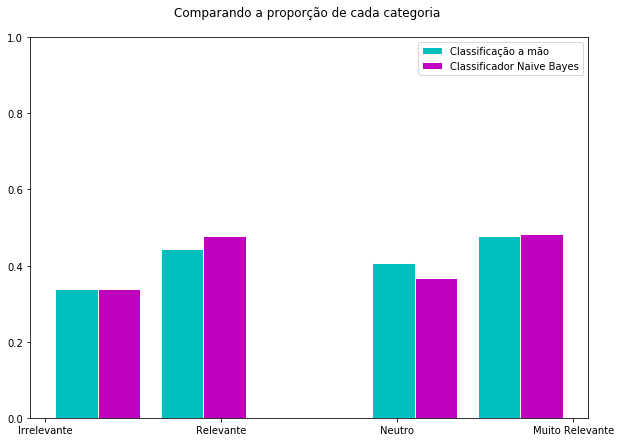

In [32]:
plt.figure(figsize=(10, 7))


plt.hist([test['RELEVANCIA'], test['RELEVANCIA (Naive Bayes)']], color=['c','m'], \
         label=['Classificação a mão', 'Classificador Naive Bayes'], edgecolor='white', bins=5, density=True)
plt.title('Comparando a proporção de cada categoria \n')
plt.ylim(0, 1.0)
plt.legend()

plt.show()

___
### Concluindo

#### Faça um comparativo qualitativo sobre os percentuais obtidos para que possa discutir a performance do seu classificador.
##### Explique como são tratadas as mensagens com dupla negação e sarcasmo.
##### Proponha um plano de expansão. Por que eles devem continuar financiando o seu projeto?


A performance de nosso classificador não foi tão boa quanto o esperado, com um acerto médio percentual de classificação dos tweets (verdadeiros de cada categoria) de cerca de 48,00%.

Isso provavelmente se deve a vários fatores, como a dificuldade do classificador em entender tweets com sarcasmo, ironia, gírias, memes, entre outros, e o fato de que a diferença entre tweets relevantes e muito relevantes foi muito sutil enquanto classificávamos à mão.

Também pode ter havido muitas divergências durante o processo de classificação dos tweets, pois se tratava de três pessoas diferentes realizando a categorização em um curto período de tempo. Assim, caso a equipe recebesse um financiamento, poderia investir em um treinamento/capacitação para classificar os tweets de forma mais semelhante.

Além disso, o projeto poderia ser expandido para classificar uma quantidade maior de tweets relacionados à Catupiry e encaminhar estratégias para trabalhar com Marketing. Por exemplo, o projeto poderia reconhecer perfis (por meio dos @s) populares e frequentemente mencionados nesses tweets para possivelmente realizar parcerias para divulgação, ou então reconhecer memes e outras possíveis abordagens atraentes ao público-alvo.

####  Discorrer por que não posso alimentar minha base de Treinamento automaticamente usando o próprio classificador, aplicado a novos tweets.

O classificador ficaria cada vez mais impreciso e ineficaz se utilizássemos o próprio classificador para categorizar algumas amostras de tweets e, então, treiná-lo com elas. Afinal, o classificador não é uma pessoa, portanto não é capaz de reconhecer certas variações nos tweets e interpretá-los corretamente, como sarcasmo, memes, ironia, contexto dos tweets, abreviações, entre outros.

Ou seja, se fizéssemos isso, o classificador consideraria os erros cometidos durante sua classificação como acertos e, portanto, seria treinado de maneira incorreta. Assim, a quantidade de erros considerados corretos iria aumentar a cada vez que isso fosse feito e o classificador ficaria cada vez menos preciso e eficaz.

#### Propor diferentes cenários de uso para o classificador Naive-Bayes. Pense em outros cenários sem intersecção com este projeto.

O Naive Bayes, em conjunto com outros classificadores, pode ser utilizado na detecção de fraudes no seguro de automóveis, no qual um caso desconhecido é avaliado e classificado como uma possível fraude ou como um caso legítimo (2 categorias). Desse modo, caso o classificador identifique uma fraude, é possível tomar medidas legais para investigar o caso mais a fundo.

Além disso, ele pode ser usado em seguros automobilísticos de outra maneira, analisando a probabilidade dos clientes renovarem ou não o seguro (2 categorias). Dessa forma, as seguradoras passam a ter um conhecimento maior a respeito do mercado, de suas vendas e de seus clientes, influenciando em sua tomada de decisão.

Esse classificador também pode ser usado em modelos de Credit Scoring, em que se estima a probabilidade do cliente que busca aplicar ao crédito se tornar ou não inadimplente (2 categorias), ou seja, não pagar a dívida, baseado em informações pessoais e financeiras do cliente. Assim, é possível tomar uma decisão a respeito da aprovação (ou não) do crédito para o cliente.

Fontes:
    - http://tede.mackenzie.br/jspui/bitstream/tede/1443/1/Luis%20Alexandre%20Rodrigues.pdf
    - http://www.ica.ele.puc-rio.br/Arquivos/monografias/TCC%20-%20BRUNA%20C.%20P.%20BRUM%20Estima%C3%A7%C3%A3o%20da%20Taxa%20de%20Churn%20para%20Clientes%20de%20uma%20Seguradora%20baseado%20em%20T%C3%A9cnicas%20de%20Reconhecimento%20de%20Padr%C3%B5es.pdf
    - https://www.teses.usp.br/teses/disponiveis/3/3142/tde-25052009-162507/publico/Dissertacao_Cristiane_Karcher_revisada.pdf

___
## Aperfeiçoamento:

Os trabalhos vão evoluir em conceito dependendo da quantidade de itens avançados:

* $OK$ Limpar: \n, :, ", ', (, ), etc SEM remover emojis 
* $OK$ Corrigir separação de espaços entre palavras e emojis ou entre emojis e emojis 
* $OK$ Propor outras limpezas e transformações que não afetem a qualidade da informação ou classificação 
* $OK$ Criar categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante (3 categorias: C, mais categorias conta para B) 

* $OK$ Explicar por que não posso usar o próprio classificador para gerar mais amostras de treinamento
* $OK$ Propor diferentes cenários para Naïve Bayes fora do contexto do projeto

* Sugerir e explicar melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)

* $OK$ Montar um dashboard que realiza análise de sentimento e visualiza estes dados

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**